In [1]:
#standard imports and setups used during EAE127
import math
import numpy as np 
import os
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
#Disable Python Warning Output
#(NOTE: Only for production, comment out for debugging)
import warnings
warnings.filterwarnings('ignore')
### PLOTTING DEFAULTS BOILERPLATE (OPTIONAL) #########################
#SET DEFAULT FIGURE APPERANCE
import seaborn as sns #Fancy plotting package 
#No Background fill, legend font scale, frame on legend
sns.set_theme(style='whitegrid', font_scale=1.5, rc={'legend.frameon': True})
#Mark ticks with border on all four sides (overrides 'whitegrid')
sns.set_style('ticks')
#ticks point in
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
#fix invisible marker bug
sns.set_context(rc={'lines.markeredgewidth': 0.1})
#restore default matplotlib colormap
mplcolors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
'#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
sns.set_palette(mplcolors)

#Get color cycle for manual colors
colors = sns.color_palette()
#SET MATPLOTLIB DEFAULTS
#(call after seaborn, which changes some defaults)
params = {
#FONT SIZES
'axes.labelsize' : 30, #Axis Labels
'axes.titlesize' : 30, #Title
'font.size' : 28, #Textbox
'xtick.labelsize': 22, #Axis tick labels
'ytick.labelsize': 22, #Axis tick labels
'legend.fontsize': 15, #Legend font size
'font.family' : 'serif',
'font.fantasy' : 'xkcd',
'font.sans-serif': 'Helvetica',
'font.monospace' : 'Courier',
#AXIS PROPERTIES
'axes.titlepad' : 2*6.0, #title spacing from axis
'axes.grid' : True, #grid on plot
'figure.figsize' : (8,8), #square plots
'savefig.bbox' : 'tight', #reduce whitespace in saved figures
#LEGEND PROPERTIES
'legend.framealpha' : 0.5,
'legend.fancybox' : True,
'legend.frameon' : True,
'legend.numpoints' : 1,
'legend.scatterpoints' : 1,
'legend.borderpad' : 0.1,
'legend.borderaxespad' : 0.1,
'legend.handletextpad' : 0.2,
'legend.handlelength' : 1.0,
'legend.labelspacing' : 0,
}
import matplotlib #type:ignore
matplotlib.rcParams.update(params) #update matplotlib defaults, call after￿
### END OF BOILERPLATE ##################################################
colors = sns.color_palette() #color cycle

In [4]:
#main code

ka = 1.402899
kd = 1.399711
kc = 1.381118
kt = 1.322798
kn = 1.335846

Cpc = 0.248448
Cpb = 0.2727997
Cpt = 0.2809486
Cpn = 0.2726974

piC = 15
piB = 0.95
piD = 0.92

R = 53.35 #ft * lbf / (lbm * Rankine)

mdot = 165 #lbm/s
deltaH = 17800 #Btu/lbm
Tt4 = 2500 #Rankine

Pa = 14.696 #ambient pressure
Ta = 518.67 #ambient temperature

Ma = 0.75

etaC = 0.91
etaB = 0.91
etaT = 0.85
etaN = 0.96
etaM = 0.995


In [48]:
def calcThrust(piCvar=piC):
    aa = np.sqrt(ka*R*Ta*32.17)
    ua = Ma*aa
    
    #diffuser
    Pta = Pa * (1 + (ka-1)/2*Ma**2)**(ka/(ka-1))
    Pt2 = Pta * piD
    Tt2 = Ta * (1 + (ka-1)/2 * Ma**2)

    #compressor
    Pt3 = Pt2 * piCvar
    tauC = (piCvar**((kc-1)/kc)-1)/etaC + 1
    Tt3 = Tt2 * tauC

    #combustor
    Pt4 = Pt3 * piB

    mdot_f = mdot*Cpb*(Tt4 - Tt3)/(deltaH*etaB - Cpb*Tt4)

    #turbine
    Tt5 = Tt4 - (mdot*Cpc*(Tt3 - Tt2))/(etaM*(mdot+mdot_f)*Cpt)

    tauT = Tt5/Tt4
    piT = (1-(1-tauT)/etaT)**(kt/(kt-1))
    Pt5 = Pt4*piT
    Pt6 = Pt5

    #nozzle
    p8 = Pt6 * (1 + (1-kn)/(etaN*(1+kn)))**(kn/(kn-1))
    M8 = 1
    Tt6 = Tt5
    Tt8prime = Tt6
    
    T8prime = Tt8prime / (1 + (kn - 1)/2)

    T8 = Tt6 - etaN*(Tt6 - T8prime)
    a8 = np.sqrt(kn*R*T8*32.17)

    u8 = a8

    rho8 = p8/(R*T8)*144
    A8 = (mdot+mdot_f)/(rho8 * u8) * 144

    F = ((mdot+mdot_f)*u8 - mdot * ua)/32.17 + A8*(p8 - Pa)
    TSFC = mdot_f/F * 3600
    Fbar = F/(mdot*aa) *32.17

    return F, TSFC, Fbar

F, TSFC, Fbar = calcThrust()

print("Thrust: {:.6g} lbf, TSFC: {:.6g} lbm/lbf*hr, Fbar: {:.6g}".format(F,TSFC,Fbar))


Thrust: 10326.7 lbf, TSFC: 1.23118 lbm/lbf*hr, Fbar: 1.80168


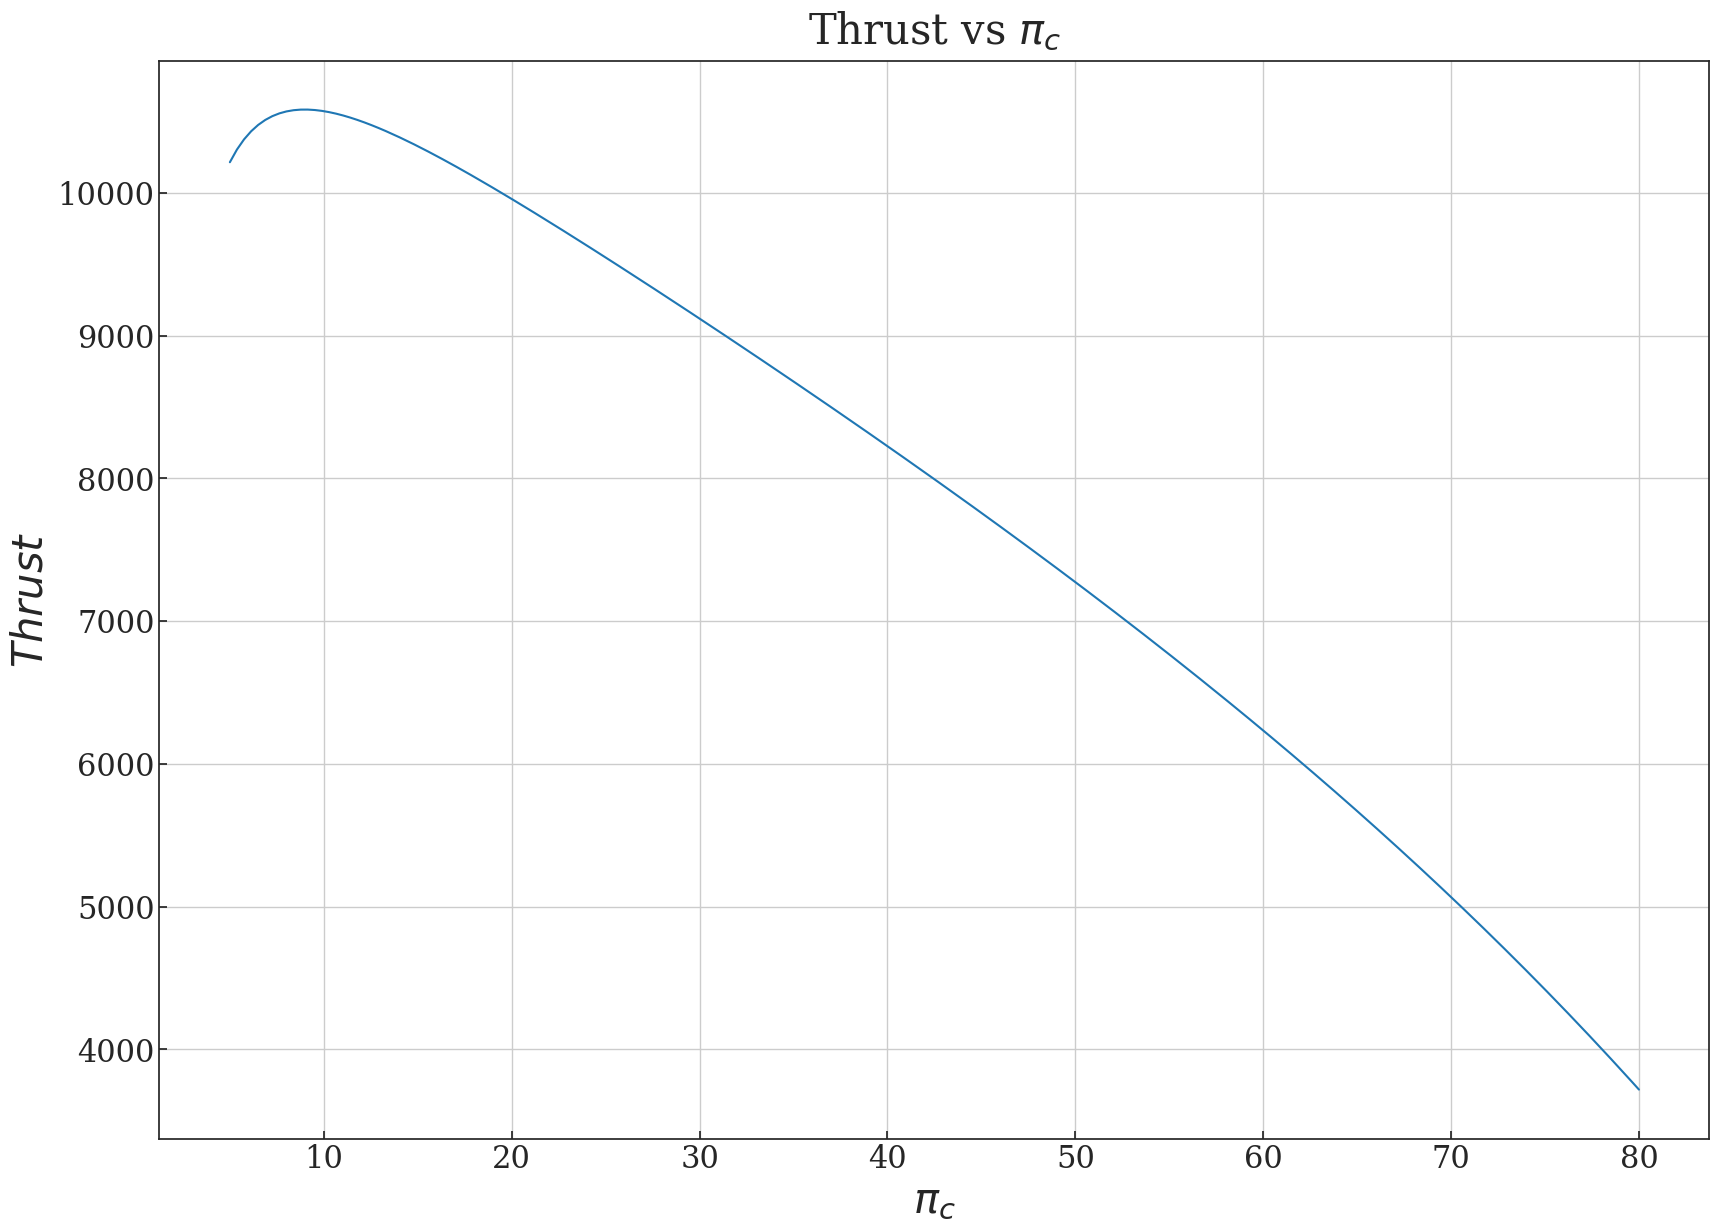

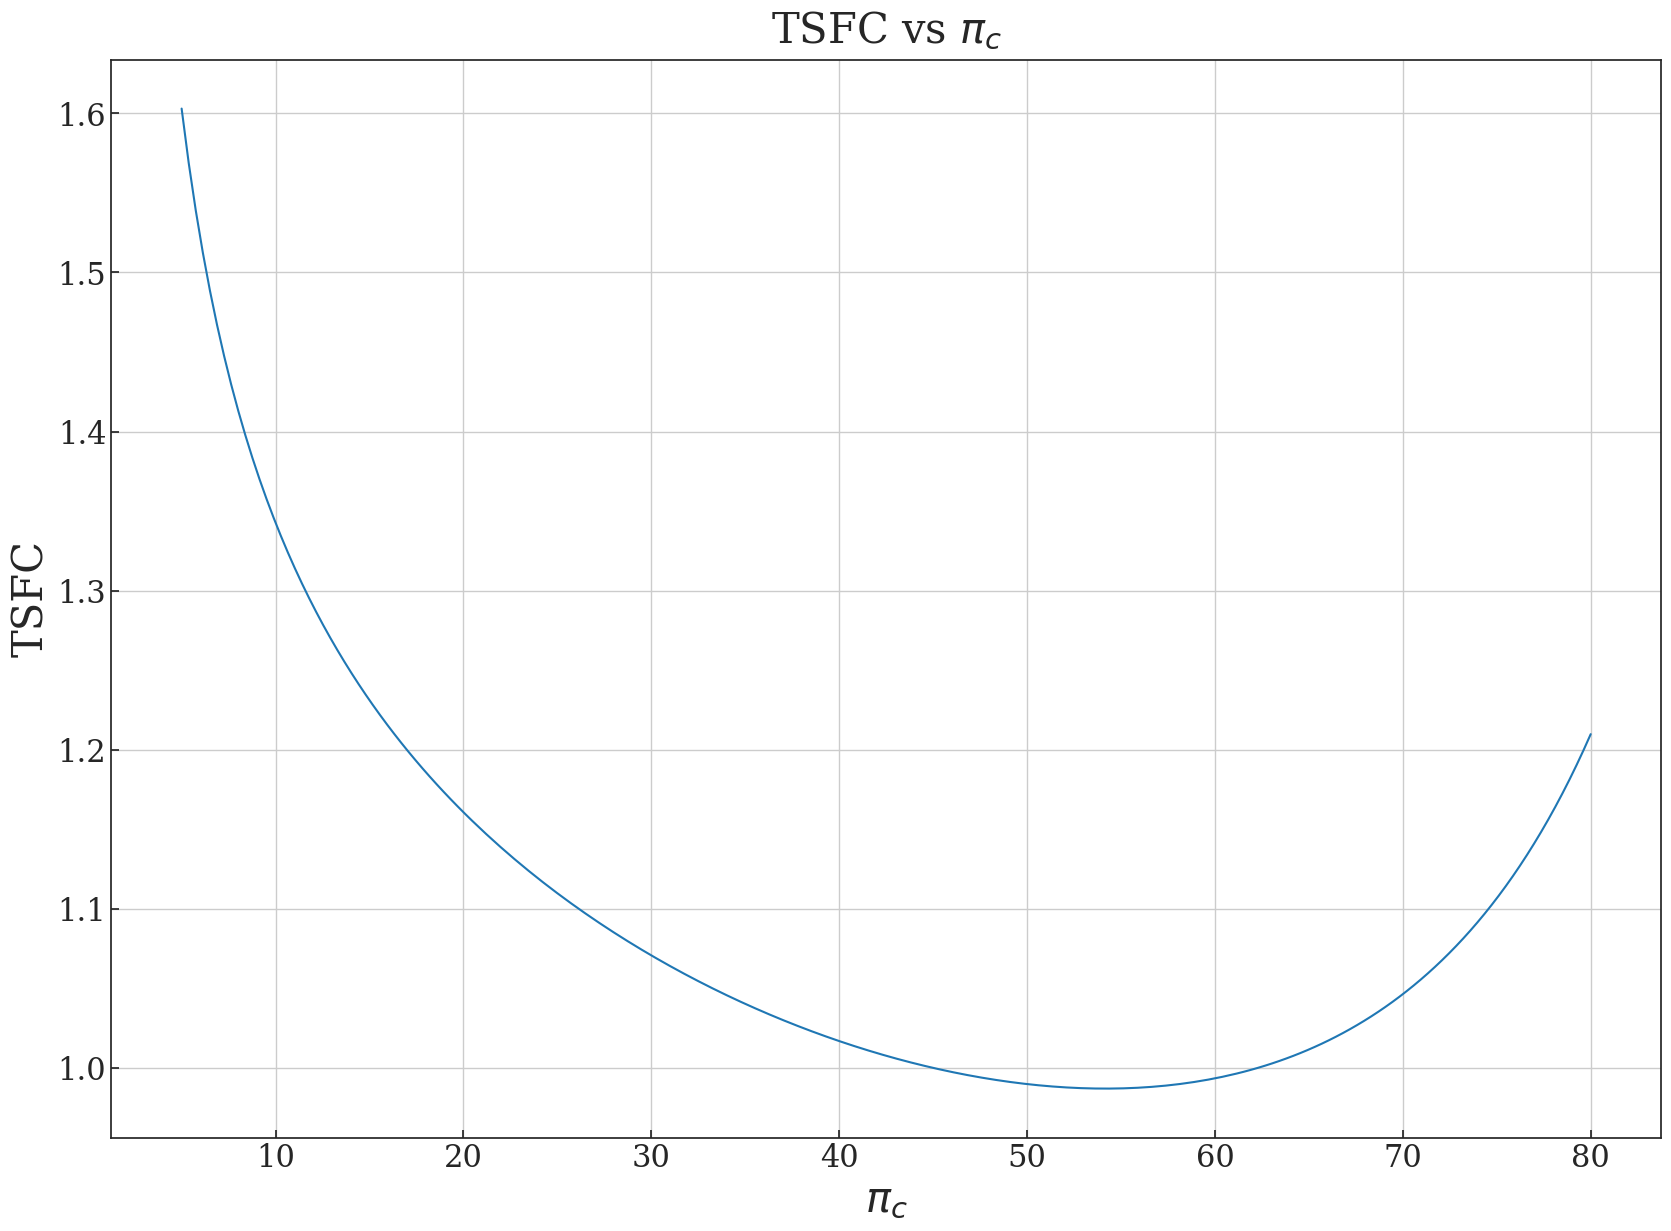

In [49]:
x = np.linspace(5,80,200)
Ft, TSFC, Fbar = calcThrust(piCvar=x)

plt.figure(figsize=(20,14))
plt.title(r"Thrust vs $\pi_c$")
plt.plot(x,Ft)
plt.xlabel(r"$\pi_c$")
plt.ylabel(r"$Thrust$")
plt.show()

plt.figure(figsize=(20,14))
plt.title(r"TSFC vs $\pi_c$")
plt.plot(x,TSFC)
plt.xlabel(r"$\pi_c$")
plt.ylabel(r"TSFC")
plt.show()